# RNN Encoder - Decoder

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
from collections import defaultdict
from transformers import BertModel, BertConfig, BertTokenizer
import matplotlib.pyplot as plt

## Recent in NLP Area

- PML(Pretrained Language Model)
    - first train a big language model with huge dataset
    - second 'fine-tuning' with down-stream task, like classficiation ...
    - similar with 'Transfer Learning'
- Well organized packages: Transfomers
    - link: https://huggingface.co/transformers/

## QA Data: 

A dataset which have questions and answers questions across multiple domains (restaurants, retail, complaints, etc.)

```
# Example 1:
Q: 너무 비싼데 개인 헤드셋 가져와서 사용해도 되나요? 
A: 개인 헤드셋을 가져오셔서 사용하시는 건 자유입니다
# Example 2:
Q: 물티슈도 있나요? 
A: 아니요 물티슈는 따로 구비되어 있지 않습니다
```

In [3]:
data = pd.read_csv("./data/dialog.tsv", sep="\t", encoding="utf-8", header=None).rename(columns=dict(enumerate(["Q", "A"])))
data.head()

,Q,A
0,너무 비싼데 개인 헤드셋 가져와서 사용해도 되나요?,개인 헤드셋을 가져오셔서 사용하시는 건 자유입니다
1,물티슈도 있나요?,아니요 물티슈는 따로 구비되어 있지 않습니다
2,그럼 여기 베그도 가맹점인가요?,네 그렇습니다
3,가맹점 혜택이 뭔데요?,몇 가지 아이템을 더 사용하실 수 있어요
4,여기 피파온라인 가맹점인가요?,네 피파 가맹점입니다


## Transfomers Tokenizer

In [4]:
model_path = "beomi/kcbert-base"
tokenizer = BertTokenizer.from_pretrained(model_path, add_special_tokens=True, additional_special_tokens=["[S]", "[E]"])
model = BertModel.from_pretrained(model_path)
model.resize_token_embeddings(len(tokenizer))

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of the model checkpoint at beomi/kcbert-base were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Embedding(30002, 768)

In [7]:
# use tokenizer as function
tokenizer("여기 뭐하는 곳인가요?")

{'input_ids': [2, 8225, 10258, 313, 9410, 32, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

In [8]:
class QADataset(Dataset):
    def __init__(self, data_path, fmt="\t", end_tkn="[E]"):
        # read files
        data = pd.read_csv(data_path, sep=fmt, encoding="utf-8", header=None).rename(columns=dict(enumerate(["Q", "A"])))
        self.Q = data["Q"].tolist()
        self.A = (data["A"] + end_tkn).tolist()
        
    def __getitem__(self, index):
        # return the matched index data
        return self.Q[index], self.A[index]
        
    def __len__(self):
        # length of dataset
        return len(self.Q)

In [9]:
data_path = "./data/dialog.tsv"
qads = QADataset(data_path, fmt="\t", end_tkn="[E]")
data_loader = DataLoader(qads, batch_size=128, shuffle=True)

In [10]:
# See if our dataset has too much untokenizable sentences
unk_tokens_q = 0
unk_tokens_a = 0
total_tokens_q = 0
total_tokens_a = 0
for q, a in data_loader:
    
    q = tokenizer(q, return_tensors="pt", add_special_tokens=False, padding=True, return_token_type_ids=False, return_attention_mask=False)["input_ids"]
    a = tokenizer(a, return_tensors="pt", add_special_tokens=False, padding=True, return_token_type_ids=False, return_attention_mask=False)["input_ids"]
    unk_tokens_q += (q == tokenizer.unk_token_id).sum().item()
    unk_tokens_a += (a == tokenizer.unk_token_id).sum().item()
    total_tokens_q = q.size(0) * q.size(1)
    total_tokens_a = a.size(0) * a.size(1)

print(f"UNK Tokens in Questions: {unk_tokens_q / total_tokens_q * 100: .2f} %")
print(f"UNK Tokens in Answers: {unk_tokens_a / total_tokens_a * 100: .2f} %")

UNK Tokens in Questions:  3.12 %
UNK Tokens in Answers:  0.24 %


In [11]:
for q, a in data_loader:
    q = tokenizer(q, return_tensors="pt", add_special_tokens=False, padding=True, return_token_type_ids=False, return_attention_mask=False)["input_ids"]
    a = tokenizer(a, return_tensors="pt", add_special_tokens=False, padding=True, return_token_type_ids=False, return_attention_mask=False)["input_ids"]
    break

In [14]:
q

tensor([[ 8245,  1052,  9364,  ...,     0,     0,     0],
        [ 8614, 11703,  8105,  ...,     0,     0,     0],
        [ 8225,  2269,  9068,  ...,     0,     0,     0],
        ...,
        [ 3354,  4216, 13344,  ...,     0,     0,     0],
        [ 9703,  1849,  4681,  ...,     0,     0,     0],
        [19975,  9703, 13747,  ...,     0,     0,     0]])

In [19]:
tokenizer.decode(q[22])

'거봉 국내산이에요? [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [15]:
a

tensor([[11237, 29034, 10676,  ...,     0,     0,     0],
        [11076, 11090,  8476,  ...,     0,     0,     0],
        [  654,   786, 11061,  ...,     0,     0,     0],
        ...,
        [  654,    15, 13344,  ...,     0,     0,     0],
        [ 1849,  4681,  8982,  ...,     0,     0,     0],
        [  654, 13747, 19523,  ...,     0,     0,     0]])

In [20]:
tokenizer.decode(a[22])

'네 국내산이에요. [E] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

## Encoder

In [21]:
class Encoder(nn.Module):
    """Encoder"""
    def __init__(self, embedding_weight, vocab_size, hidden_size, bidirec=False):
        super().__init__()        
        self.hidden_size = hidden_size
        self.n_direc = 2 if bidirec else 1
        
        # Embedding Layer: Embedding(30002, 768, padding_idx=0)
        self.embedding = nn.Embedding(vocab_size, hidden_size, padding_idx=0)
        self.embedding.weight.data = embedding_weight
        # Encoder RNN
        self.gru = nn.GRU(hidden_size, 
                          hidden_size, 
                          bidirectional=bidirec, 
                          batch_first=True)

    def forward(self, inputs):
        """
        Inputs:
        - inputs: (B, T_e)
        Outputs:
        - hiddens: (1, B, H_e)
        ==========================================
        B: Mini Batch size
        T_e: Encoder Max Length of Tokens
        E_e: Encoder Embedding Size
        H_e: Encoder Hidden Size
        """
        # (B, T_e) > (B, T_e, E_e)
        inputs = self.embedding(inputs)
        
        # gru 
        # outputs: (B, T_e, n_direc*H_e)
        # hiddens: (n_direc*n_layers, B, H_e)
        _, hiddens = self.gru(inputs)
        
        # Take the last hidden vector
        # last_hidden: (n_direc*n_layers, B, H_e) > (B, H_e)
        # summation the last hidden
        last_hidden = hiddens[-self.n_direc:].sum(0)
        
        # unsqueeze last_hidden: (1, B, H_e)
        return last_hidden.unsqueeze(0)

In [22]:
encoder = Encoder(
    embedding_weight=model.embeddings.word_embeddings.weight.data,
    vocab_size=len(tokenizer), 
    hidden_size=768,
    bidirec=True
)
enc_hiddens = encoder(q)
enc_hiddens.size()

torch.Size([1, 128, 768])

## Decoder

In [23]:
class Decoder(nn.Module):
    """Decoder"""
    def __init__(self, embedding_weight, vocab_size, hidden_size, start_idx, end_idx):
        super().__init__()
        self.hidden_size = hidden_size
        self.start_idx = start_idx
        self.end_idx = end_idx
        # Embedding Layer: Embedding(30002, 768, padding_idx=0)
        self.embedding = nn.Embedding(vocab_size, hidden_size, padding_idx=0)
        self.embedding.weight.data = embedding_weight
        # Decoder RNN
        self.gru = nn.GRU(
            hidden_size, 
            hidden_size, 
            bidirectional=False, 
            batch_first=True
        )
        # Final Linear Layer
        self.linear = nn.Linear(hidden_size, vocab_size, bias=False)
        self.linear.weight.data = embedding_weight

    def init_sos(self, batch_size, device):
        # Create Tensor with start token: [S]
        return torch.LongTensor([self.start_idx]*batch_size).unsqueeze(1).to(device)
    
    def forward(self, enc_hiddens, gold=None, max_len=None):
        """
        Inputs:
        - enc_hiddens: (1, B, H_d)
        - max_len: T_d, if it is None means at training phase
        - gold: answer token if it is not None means using Teacher Force Model
        Outputs:
        - scores: results of all predictions = (B, T_d, vocab_size)
        ==========================================
        B: Mini Batch size
        T_d: Decoder Max Length of Tokens
        E_d: Decoder Embedding Size
        H_d: Decoder Hidden Size
        V_d: Vocab Length
        """
        max_len = gold.size(1) if max_len is None else max_len
        batch_size = enc_hiddens.size(1)
        # initialize input tokens with start token [S]: (B, 1)
        inputs = self.init_sos(batch_size, device=enc_hiddens.device)
        
        # (B, 1) > (B, 1, E_d)
        inputs = self.embedding(inputs)
        
        scores = []
        hiddens = enc_hiddens
        for i in range(0, max_len):
            # hiddens = (1, B, H_d)
            _, hiddens = self.gru(inputs, hiddens)
            
            # score = (1, B, H_d) > (B, H_d) > (B, V_d)
            score = self.linear(hiddens.squeeze(0))
            scores.append(score)
            
            if gold is not None:
                # Training
                pred = gold[:, i]  # (B,)
            else:
                # Testing
                # predict next token score
                pred = score.softmax(-1).argmax(-1)  # (B,)
                # stop when the token is end_idx
                if (pred == self.end_idx).sum() == batch_size:  # all stop
                    break
                
            inputs = self.embedding(pred.unsqueeze(1))

        # (T_d, B, vocab_size) > (B, T_d, vocab_size)
        scores = torch.stack(scores).transpose(0, 1)
        return scores

In [24]:
decoder = Decoder(
    embedding_weight=model.embeddings.word_embeddings.weight.data,
    vocab_size=len(tokenizer), 
    hidden_size=768,
    start_idx=tokenizer.all_special_ids[-2],
    end_idx=tokenizer.all_special_ids[-1]
)
scores = decoder(enc_hiddens, gold=a, max_len=None)
scores.size()

torch.Size([128, 69, 30002])

## Model: Encoder-Decoder

In [25]:
class EncoderDecoder(nn.Module):
    """Encoder - Decoder"""
    def __init__(self, embedding_weight, vocab_size, hidden_size, start_idx, end_idx, bidirec=False):
        """
        Class for linking encoder and decoder
        """
        super().__init__()
        self.encoder = Encoder(
            embedding_weight=embedding_weight,
            vocab_size=vocab_size,
            hidden_size=hidden_size,
            bidirec=bidirec
        )
        self.decoder = Decoder(
            embedding_weight=embedding_weight,
            vocab_size=vocab_size,
            hidden_size=hidden_size,
            start_idx=start_idx,
            end_idx=end_idx
        )
        
    def forward(self, input_qs, input_as, max_len=None):
        """
        scores 크기: (B*(T_d), vocab_size)
        """
        enc_hiddens = self.encoder(input_qs)
        scores = self.decoder(enc_hiddens, gold=input_as, max_len=max_len)
        return scores
    
    def load_embeddings(self, state_dict):
        self.encoder.embedding.weight.data = state_dict['encoder.embedding.weight']
        self.decoder.embedding.weight.data = state_dict['decoder.embedding.weight']

## Define Dataset and model

In [26]:
data_path = "./data/dialog.tsv"
qads = QADataset(data_path, fmt="\t", end_tkn="[E]")
data_loader = DataLoader(qads, batch_size=25, shuffle=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
model_path = "beomi/kcbert-base"
tokenizer = BertTokenizer.from_pretrained(model_path, add_special_tokens=True, additional_special_tokens=["[S]", "[E]"])
model_bert = BertModel.from_pretrained(model_path)
model_bert.resize_token_embeddings(len(tokenizer))
hidden_size = 768
vocab_size = len(tokenizer)
bidirec = True

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of the model checkpoint at beomi/kcbert-base were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [27]:
# define model
model = EncoderDecoder(
    embedding_weight=model_bert.embeddings.word_embeddings.weight.data, 
    vocab_size=vocab_size,
    hidden_size=hidden_size, 
    start_idx=tokenizer.all_special_ids[-2], 
    end_idx=tokenizer.all_special_ids[-1], 
    bidirec=bidirec
).to(device)

# define optimizer and loss function
loss_function = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

## Model Training

### Train function

In [13]:
def train(model, tokenizer, data_loader, loss_function, optimizer, print_step, device):
    # Training
    total_loss = 0
    vocab_size = len(tokenizer)
    n_train = len(data_loader.dataset)
    model.train()
    
    for batch_idx, (q, a) in enumerate(data_loader):
        # Tokenize
        input_qs = tokenizer(q, return_tensors="pt", add_special_tokens=False, padding=True, return_token_type_ids=False, return_attention_mask=False)["input_ids"]
        input_as = tokenizer(a, return_tensors="pt", add_special_tokens=False, padding=True, return_token_type_ids=False, return_attention_mask=False)["input_ids"]
        input_qs, input_as = input_qs.to(device), input_as.to(device)
        
        optimizer.zero_grad()
        scores = model(input_qs, input_as, max_len=None)
        loss = loss_function(scores.contiguous().view(-1, vocab_size), input_as.contiguous().view(-1))
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        if batch_idx % print_step == 0:
            percentage = (batch_idx*data_loader.batch_size / n_train) * 100
            print(f" - [{percentage:.2f}%] train loss: {loss:.4f}")
    return total_loss

In [14]:
n_step = 10
print_step = 200
best_loss = 999999

for step in range(n_step):
    print(f"[Step] {step+1}/{n_step}")
    train_loss = train(model, tokenizer, data_loader, loss_function, optimizer, print_step, device)
    print(f" - Train Average Loss: {train_loss:.4f}")
    
    if train_loss < best_loss:
        best_loss = train_loss
        torch.save(model.state_dict(), "./states/best_model-chat.pt")
        print("[Alert] Best Model Saved")

[Step] 1/10
 - [0.00%] train loss: 10.3081
 - [11.36%] train loss: 5.0474
 - [22.72%] train loss: 4.5721
 - [34.07%] train loss: 4.3695
 - [45.43%] train loss: 4.1076
 - [56.79%] train loss: 4.0945
 - [68.15%] train loss: 4.0843
 - [79.51%] train loss: 3.8699
 - [90.87%] train loss: 3.5343
 - Train Average Loss: 8172.8449
[Alert] Best Model Saved
[Step] 2/10
 - [0.00%] train loss: 3.7011
 - [11.36%] train loss: 3.2771
 - [22.72%] train loss: 2.7020
 - [34.07%] train loss: 3.9001
 - [45.43%] train loss: 3.7935
 - [56.79%] train loss: 3.2162
 - [68.15%] train loss: 3.5063
 - [79.51%] train loss: 3.9732
 - [90.87%] train loss: 3.5043
 - Train Average Loss: 6142.2792
[Alert] Best Model Saved
[Step] 3/10
 - [0.00%] train loss: 2.4753
 - [11.36%] train loss: 2.3496
 - [22.72%] train loss: 3.4115
 - [34.07%] train loss: 2.7826
 - [45.43%] train loss: 2.9063
 - [56.79%] train loss: 2.7584
 - [68.15%] train loss: 2.6779
 - [79.51%] train loss: 2.5897
 - [90.87%] train loss: 3.4225
 - Train Aver

In [55]:
load_path = "./states/best_model-chat.pt"
device = torch.device('cpu')
model = EncoderDecoder(
    embedding_weight=model_bert.embeddings.word_embeddings.weight.data, 
    vocab_size=vocab_size,
    hidden_size=hidden_size, 
    start_idx=tokenizer.all_special_ids[-2], 
    end_idx=tokenizer.all_special_ids[-1], 
    bidirec=bidirec
).to(device)
state_dict = torch.load(load_path, map_location=device)
model.load_state_dict(state_dict)
model.load_embeddings(state_dict)
model.eval()

def chat_program(model, tokenizer, max_len, device):
    model.eval()
    print("[exit() 를 입력하면 종료할 수 있습니다.]")
    print()
    switch = True
    while switch:
        txt = input("질의: ")
        input_qs = tokenizer([txt], return_tensors="pt", add_special_tokens=False, padding=True, return_token_type_ids=False, return_attention_mask=False)["input_ids"]
        with torch.no_grad():
            scores = model(input_qs.to(device), input_as=None, max_len=max_len)
        preds = scores.argmax(-1).squeeze().detach()
        if txt == "exit()":
            switch=False
        else:
            print(f'대답:  {tokenizer.decode(preds).strip("[E]")}')

In [56]:
chat_program(model, tokenizer, max_len=50, device=device)

[exit() 를 입력하면 종료할 수 있습니다.]



질의:  안녕하세요


대답:  안녕. 


질의:  여기 던파 가맹점임?


대답:  피클 본사에서 내려와요 


질의:  뭐라구요?


대답:  아뇨 앉으시면 돼요 


질의:  뭐하면 될까요?


대답:  과일주스나 같이 드시려면게요 


질의:  커피 있나요?


대답:  커피는 셀프였으면 좋겠어요 


질의:  exit()


---

# Attention Machanisim

## Attention

How to create context?

* Batch Size=1, Embedding Size=30, Max Length of Tokens=5, Hidden Size=50
* RNN: 1 layer single direction

In [58]:
torch.manual_seed(77)
B = 2
E = 30
T = 5
H = 50

inputs = torch.randn(B, T, E)
hiddens = torch.zeros(1, B, H)

rnn_layer = nn.RNN(E, H, batch_first=True)

In [59]:
torch.manual_seed(77)
encoder_hiddens, hiddens = rnn_layer(inputs, hiddens)
decoder_hiddens = torch.randn(1, B, H)  # decoder at t-timestamp for example

print(f"Encoder All Time Stpes Hiddem Size: {encoder_hiddens.size()}")
print(f"Decoder Certain Stpe Hiddem Size: {decoder_hiddens.size()}")

Encoder All Time Stpes Hiddem Size: torch.Size([2, 5, 50])
Decoder Certain Stpe Hiddem Size: torch.Size([1, 2, 50])


### 1. Attention Score

$$s_{ij} = \alpha(d_{i-1}, e_j) = d_{i-1} \cdot e_j^T$$

* `bmm` 배치 끼리 매트릭스 곱을 수행한다. 

```
matrix1 = (B, 10, 5)
matrix2 = (B, 5, 2)
torch.bmm(matrix1, matrix2) = (B, 10, 5) x (B, 5, 2) = (B, 10, 2)
```

In [60]:
e = encoder_hiddens   # (B, T, H)
d = decoder_hiddens.transpose(1, 0)  # (1, B, H) > (B, 1, H)
scores = torch.bmm(d, e.transpose(1, 2))
print(scores.size())
print()
print(scores.data)

torch.Size([2, 1, 5])

tensor([[[-0.7028, -2.8749, -3.6744, -4.6765, -3.1657]],

        [[-0.4469,  1.2336, -2.0815, -0.0484, -5.5157]]])


In [61]:
# using for loop(loop each batch data) to see if it is same
batch = []
for single_e, single_d in zip(e, d):
    score = []
    for e_j in single_e:
        # e_j = 50, d_{i-1}=50
        s = single_d.squeeze().dot(e_j)
        score.append(s)
    batch.append(torch.stack(score).unsqueeze(0))
scores = torch.stack(batch)

print(scores.size())
print()
print(scores.data)

torch.Size([2, 1, 5])

tensor([[[-0.7028, -2.8749, -3.6744, -4.6765, -3.1657]],

        [[-0.4469,  1.2336, -2.0815, -0.0484, -5.5157]]])


### 2. Attention distribution

$$a_{ij} = \dfrac{\exp(s_{ij})}{\sum_{k=1}^N s_{ik}}$$

In [62]:
attn_dist = scores.softmax(-1)  # (B, 1, T)

In [86]:
ax.get_yticks()

array([-0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6])

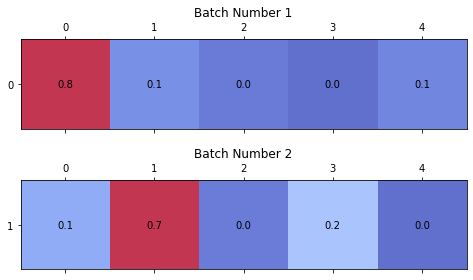

In [87]:
# draw attention distribution
data = attn_dist.detach()
fig, axes = plt.subplots(2, 1, figsize=(10, 4))
for batch_i, ax in enumerate(axes.flatten()):
    ax.matshow(data[batch_i], cmap="coolwarm", alpha=0.8)
    ax.set_title(f"Batch Number {batch_i+1}")
    ax.set_yticks([0])
    ax.set_yticklabels([batch_i])
    for (i, j), z in np.ndenumerate(data[batch_i]):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
        
plt.tight_layout(h_pad=1.5)
plt.show()

### 3. Context Vector

$$c_t = \sum_{i=1}^N a_i^t e_i$$

In [88]:
# (B, 1, T) * (B, T, H) = (B, 1, H)
context = torch.bmm(attn_dist, e)
print(context.size())

torch.Size([2, 1, 50])


### 4. Concat Context

In [89]:
torch.manual_seed(77)
new_embeded = torch.randn(B, 1, E)
new_inputs = torch.cat([context, new_embeded], dim=2)
print(new_inputs.size())  # (B, 1, H + E)

torch.Size([2, 1, 80])


## QA Data

### Redefine Encoder

In [4]:
class EncoderAttn(nn.Module):
    """Encoder"""
    def __init__(self, embedding_weight, vocab_size, hidden_size, bidirec=False):
        super().__init__()        
        self.hidden_size = hidden_size
        self.n_direc = 2 if bidirec else 1
        
        # Embedding Layer: Embedding(30002, 768, padding_idx=0)
        self.embedding = nn.Embedding(vocab_size, hidden_size, padding_idx=0)
        self.embedding.weight.data = embedding_weight
        # Encoder RNN
        self.gru = nn.GRU(hidden_size, 
                          hidden_size, 
                          bidirectional=bidirec, 
                          batch_first=True)

    def forward(self, inputs):
        """
        Inputs:
        - inputs: (B, T_e)
        Outputs:
        - outputs: (B, T, H_e)
        - hiddens: (1, B, H_e)
        ==========================================
        B: Mini Batch size
        T_e: Encoder Max Length of Tokens
        E_e: Encoder Embedding Size
        H_e: Encoder Hidden Size
        """
        # (B, T_e) > (B, T_e, E_e)
        inputs = self.embedding(inputs)
        
        # gru 
        # outputs: (B, T_e, n_direc*H_e)
        # hiddens: (n_direc*n_layers, B, H_e)
        outputs, hiddens = self.gru(inputs)
        
        # Take the last hidden vector
        # last_hidden: (B, H)
        # summation the last hidden
        outputs = torch.stack(torch.chunk(outputs, chunks=2, dim=2)).sum(0)
        last_hidden = hiddens[-self.n_direc:].sum(0)
        
        # unsqueeze last_hidden: (1, B, H)
        return outputs, last_hidden.unsqueeze(0)

### Redefine Decoder with Context

In [5]:
class DecoderAttn(nn.Module):
    """Decoder"""
    def __init__(self, embedding_weight, vocab_size, hidden_size, start_idx, end_idx):
        super().__init__()
        self.hidden_size = hidden_size
        self.start_idx = start_idx
        self.end_idx = end_idx
        # Embedding Layer: Embedding(30002, 768, padding_idx=0)
        self.embedding = nn.Embedding(vocab_size, hidden_size, padding_idx=0)
        self.embedding.weight.data = embedding_weight
        # Decoder RNN
        self.gru = nn.GRU(
            2*hidden_size, 
            hidden_size, 
            bidirectional=False, 
            batch_first=True
        )
        # Final Linear Layer
        self.linear = nn.Linear(hidden_size, vocab_size, bias=False)
        self.linear.weight.data = embedding_weight

    def init_sos(self, batch_size, device):
        # Create Tensor with start token: [S]
        return torch.LongTensor([self.start_idx]*batch_size).unsqueeze(1).to(device)
    
    def forward(self, enc_outputs, enc_hiddens, gold=None, max_len=None, rt_attn=False):
        """
        Inputs:
        - enc_outputs: (B, T_e, H_d)
        - enc_hiddens: (1, B, H_d)
        - max_len: T_d, if it is None means at training phase
        - gold: answer token if it is not None means using Teacher Force Model
        Outputs:
        - scores: results of all predictions = (B, T_d, vocab_size)
        ==========================================
        B: Mini Batch size
        T_d: Decoder Max Length of Tokens
        E_d: Decoder Embedding Size
        H_d: Decoder Hidden Size
        V_d: Vocab Length
        """
        max_len = gold.size(1) if max_len is None else max_len
        batch_size = enc_hiddens.size(1)
        # initialize input tokens with start token [S]: (B, 1)
        inputs = self.init_sos(batch_size, device=enc_hiddens.device)
        
        # (B, 1) > (B, 1, E_d)
        inputs = self.embedding(inputs)
        
        scores = []
        attn_weights = []
        
        hiddens = enc_hiddens
        for i in range(0, max_len):
            # Create context
            # 1. attention scores: (B, 1, H_d) x (B, H_d, T_e) = (B, 1, T_e)
            attn_score = torch.bmm(
                hiddens.transpose(0, 1), enc_outputs.transpose(1, 2)
            )
            # 2. attention distribution: (B, 1, T_e)
            attn_dist = attn_score.softmax(-1)
            
            # 3. context matrix: (B, 1, T_e) x (B, T_e, H_d) = (B, 1, H_d)
            context = torch.bmm(attn_dist, enc_outputs)
            
            # 4. context concat: (B, 1, E_d + H_d)
            inputs = torch.cat([context, inputs], dim=2)
            
            # hiddens = (1, B, H_d)
            _, hiddens = self.gru(inputs, hiddens)
            
            # score = (1, B, H_d) > (B, H_d) > (B, V_d)
            score = self.linear(hiddens.squeeze(0))
            scores.append(score)
            attn_weights.append(attn_dist.data)
            
            if gold is not None:
                # Training
                pred = gold[:, i]  # (B,)
            else:
                # Testing
                # predict next token score
                pred = score.softmax(-1).argmax(-1)  # (B,)
                # stop when the token is end_idx
                if (pred == self.end_idx).sum() == batch_size:  # all stop
                    break
                
            inputs = self.embedding(pred.unsqueeze(1))

        # (T_d, B, vocab_size) > (B, T_d, vocab_size)
        scores = torch.stack(scores).transpose(0, 1)
        if rt_attn:
            attn_weights = torch.cat(attn_weights, 1)
            return scores, attn_weights
        return scores, None

### Model: Encoder-Decoder

In [6]:
class EncoderDecoderAttn(nn.Module):
    """Encoder - Decoder"""
    def __init__(self, embedding_weight, vocab_size, hidden_size, start_idx, end_idx, bidirec=False):
        """
        Class for linking encoder and decoder
        """
        super().__init__()
        self.encoder = EncoderAttn(
            embedding_weight=embedding_weight,
            vocab_size=vocab_size,
            hidden_size=hidden_size,
            bidirec=bidirec
        )
        self.decoder = DecoderAttn(
            embedding_weight=embedding_weight,
            vocab_size=vocab_size,
            hidden_size=hidden_size,
            start_idx=start_idx,
            end_idx=end_idx
        )
        
    def forward(self, input_qs, input_as, max_len=None, rt_attn=False):
        """
        scores 크기: (B*(T_d), vocab_size)
        """
        enc_outputs, enc_hiddens = self.encoder(input_qs)
        scores, attn = self.decoder(enc_outputs, enc_hiddens, gold=input_as, max_len=max_len, rt_attn=rt_attn)
        return scores, attn
    
    def load_embeddings(self, state_dict):
        self.encoder.embedding.weight.data = state_dict['encoder.embedding.weight']
        self.decoder.embedding.weight.data = state_dict['decoder.embedding.weight']

### Define Dataset and model

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
from collections import defaultdict
from transformers import BertModel, BertConfig, BertTokenizer
from seq2seq import QADataset, EncoderAttn, DecoderAttn, EncoderDecoderAttn, train_attn
import matplotlib.pyplot as plt

In [2]:
data_path = "./data/dialog.tsv"
qads = QADataset(data_path, fmt="\t", end_tkn="[E]")
data_loader = DataLoader(qads, batch_size=25, shuffle=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
model_path = "beomi/kcbert-base"
tokenizer = BertTokenizer.from_pretrained(model_path, add_special_tokens=True, additional_special_tokens=["[S]", "[E]"])
model_bert = BertModel.from_pretrained(model_path)
model_bert.resize_token_embeddings(len(tokenizer))
hidden_size = 768
vocab_size = len(tokenizer)
bidirec = True

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of the model checkpoint at beomi/kcbert-base were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
# define model
model = EncoderDecoderAttn(
    embedding_weight=model_bert.embeddings.word_embeddings.weight.data, 
    vocab_size=vocab_size,
    hidden_size=hidden_size, 
    start_idx=tokenizer.all_special_ids[-2], 
    end_idx=tokenizer.all_special_ids[-1], 
    bidirec=bidirec
).to(device)

# define optimizer and loss function
loss_function = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

### Training

In [4]:
n_step = 10
print_step = 200
best_loss = 999999

for step in range(n_step):
    print(f"[Step] {step+1}/{n_step}")
    train_loss = train_attn(model, tokenizer, data_loader, loss_function, optimizer, print_step, device)
    print(f" - Train Average Loss: {train_loss:.4f}")
    
    if train_loss < best_loss:
        best_loss = train_loss
        torch.save(model.state_dict(), "./states/best_model-chat-attn.pt")
        print("[Alert] Best Model Saved")

[Step] 1/10
 - [0.00%] train loss: 10.3033
 - [11.36%] train loss: 5.8855
 - [22.72%] train loss: 4.8343
 - [34.07%] train loss: 4.7663
 - [45.43%] train loss: 4.6188
 - [56.79%] train loss: 4.5900
 - [68.15%] train loss: 4.6846
 - [79.51%] train loss: 3.7652
 - [90.87%] train loss: 3.8265
 - Train Average Loss: 8200.0318
[Alert] Best Model Saved
[Step] 2/10
 - [0.00%] train loss: 3.5500
 - [11.36%] train loss: 3.2685
 - [22.72%] train loss: 3.0067
 - [34.07%] train loss: 3.6866
 - [45.43%] train loss: 3.2183
 - [56.79%] train loss: 3.6421
 - [68.15%] train loss: 2.9920
 - [79.51%] train loss: 3.7807
 - [90.87%] train loss: 3.1597
 - Train Average Loss: 6183.0205
[Alert] Best Model Saved
[Step] 3/10
 - [0.00%] train loss: 2.7957
 - [11.36%] train loss: 2.3387
 - [22.72%] train loss: 2.3950
 - [34.07%] train loss: 3.2834
 - [45.43%] train loss: 3.1261
 - [56.79%] train loss: 2.9489
 - [68.15%] train loss: 2.8510
 - [79.51%] train loss: 3.1012
 - [90.87%] train loss: 2.9077
 - Train Aver

In [32]:
load_path = "./states/best_model-chat-attn.pt"
device = torch.device('cpu')
model = EncoderDecoderAttn(
    embedding_weight=model_bert.embeddings.word_embeddings.weight.data, 
    vocab_size=vocab_size,
    hidden_size=hidden_size, 
    start_idx=tokenizer.all_special_ids[-2], 
    end_idx=tokenizer.all_special_ids[-1], 
    bidirec=bidirec
).to(device)
state_dict = torch.load(load_path, map_location=device)
model.load_state_dict(state_dict)
model.load_embeddings(state_dict)
model.eval()

def chat_program(model, tokenizer, max_len, device):
    vocab = list(tokenizer.vocab) + tokenizer.all_special_tokens[-2:]
    model.eval()
    print("[exit() 를 입력하면 종료할 수 있습니다.]")
    print()
    switch = True
    while switch:
        txt = input("질의: ")
        input_qs = tokenizer([txt], return_tensors="pt", add_special_tokens=False, padding=True, return_token_type_ids=False, return_attention_mask=False)["input_ids"]
        with torch.no_grad():
            scores, attn = model(input_qs.to(device), input_as=None, max_len=max_len, rt_attn=True)
        preds = scores.argmax(-1).squeeze().detach()
        if txt == "exit()":
            switch=False
        else:
            input_tokens = tokenizer.tokenize(txt)
            output_tokens = [vocab[k.item()] for k in preds]
            output_txt = tokenizer.decode(preds).strip("[E]")
            print(f'대답:  {output_txt}')
            # Draw Attention
            plt.close()
            attn = attn.squeeze(0).numpy()
            
            fig, ax = plt.subplots(1, 1, figsize=(8, 8))
            ax.matshow(attn, cmap="coolwarm", alpha=0.8)
            ax.set_title("Attention Matrix", fontsize=12)
            for (i, j), z in np.ndenumerate(attn):
                ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')
            ax.set_xticks(list(range(len(input_tokens))))
            ax.set_xticklabels(input_tokens)
            ax.set_yticks(list(range(len(output_tokens))))
            ax.set_yticklabels(output_tokens)
            plt.tight_layout()
            plt.show()

In [33]:
plt.rcParams["font.family"] = 'NanumBarunGothic'

[exit() 를 입력하면 종료할 수 있습니다.]



질의:  안녕


대답:  안녕하세요. 


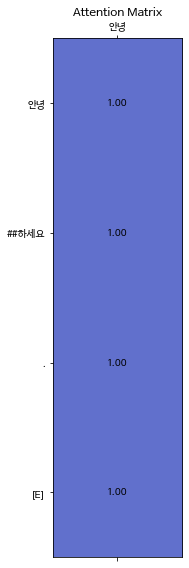

질의:  여기가 어디에요?


대답:  여기는 정가에서예요 


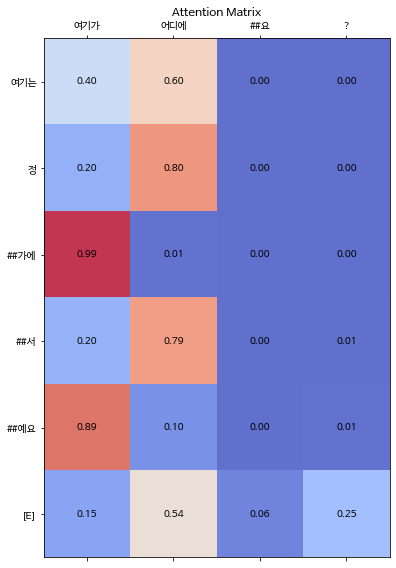

질의:  여기 물티슈 있나요?


대답:  물티슈는 이쪽에 있습니다 


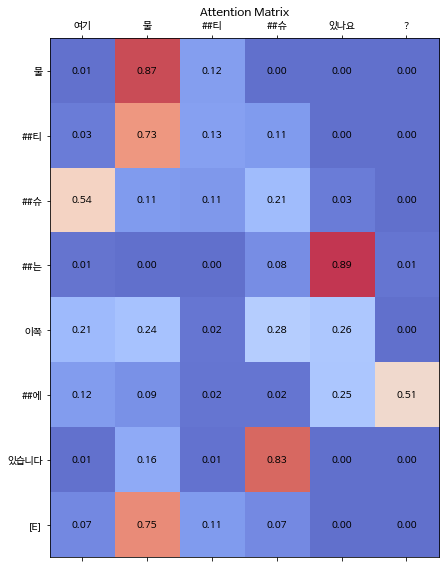

질의:  exit()


In [34]:
chat_program(model, tokenizer, max_len=50, device=device)